In [5]:
import os
import numpy as np
import rasterio
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
import shutil

In [10]:
# Function to resize and normalize an image
def resize_and_normalize(image, target_size):
    image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    image_resized = np.clip(image_resized, 0, 255) / 255.0  # Normalize to 0 to 1
    return image_resized

# Function to load and preprocess LR and HR images
def load_images(lr_image_path, hr_image_path, target_size):
    # Load and preprocess the low-resolution image
    with rasterio.open(lr_image_path) as src:
        red_band = src.read(4)  # Band 4
        green_band = src.read(3)  # Band 3
        blue_band = src.read(2)  # Band 2
        lr_image = np.dstack((red_band, green_band, blue_band))
        lr_image_resized = resize_and_normalize(lr_image, target_size)

    # Load and preprocess the high-resolution image
    hr_image = cv2.imread(hr_image_path, cv2.IMREAD_COLOR)
    hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
    hr_image = hr_image / 255.0  # Normalize to 0 to 1

    return lr_image_resized, hr_image

# Function to calculate PSNR for all images in the dataset
def calculate_psnr_for_all_images(lr_dir, hr_dir, target_size):
    lr_files = [f for f in os.listdir(lr_dir) if f.endswith('.tiff')]
    psnr_values = []

    for lr_file in lr_files:
        base_name = lr_file.replace('-L2A_data.tiff', '')
        hr_file = f"{base_name}_rgb.png"
        
        lr_image_path = os.path.join(lr_dir, lr_file)
        hr_image_path = os.path.join(hr_dir, hr_file)

        if os.path.exists(hr_image_path):
            lr_image_resized, hr_image = load_images(lr_image_path, hr_image_path, target_size)
            psnr_value = psnr(hr_image, lr_image_resized, data_range=1.0)
            psnr_values.append(psnr_value)

    return psnr_values

In [11]:
# Directories
lr_dir = 'low_resolution_final'
hr_dir = 'high_resolution_final'

target_size = (1054, 1054)

# Calculate PSNR for all image pairs
psnr_values = calculate_psnr_for_all_images(lr_dir, hr_dir, target_size)

# Calculate the average PSNR
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr:.2f} dB")

Average PSNR: 16.99 dB


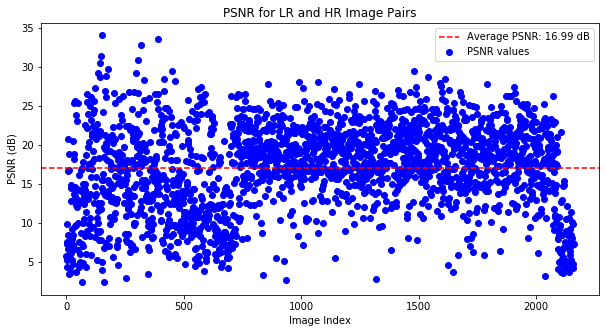

In [14]:
import matplotlib.pyplot as plt

# Plot the PSNR values as a scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(psnr_values)), psnr_values, color='blue', label='PSNR values')
plt.axhline(y=average_psnr, color='red', linestyle='--', label=f'Average PSNR: {average_psnr:.2f} dB')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')
plt.title('PSNR for LR and HR Image Pairs')
plt.legend()

# Save the plot to a file
plt.savefig('psnr_scatter_plot.png', dpi=300)

# Display the plot
plt.show()

In [14]:
output_lr_dir = 'high_psnr_lr'
output_hr_dir = 'high_psnr_hr'

# Find and save images with PSNR >= average PSNR
psnr_values = calculate_psnr_and_save_high_psnr(lr_dir, hr_dir, target_size, average_psnr, output_lr_dir, output_hr_dir)

print(f"Images with PSNR >= {average_psnr:.2f} dB have been saved to '{output_lr_dir}' and '{output_hr_dir}'")

Images with PSNR >= 16.99 dB have been saved to 'high_psnr_lr' and 'high_psnr_hr'


In [15]:
import zipfile

# Function to zip a folder
def zip_folder(folder_path, zip_name):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file), os.path.join(folder_path, '..')))

In [16]:
# Zip the folders
zip_folder(output_lr_dir, f"{output_lr_dir}.zip")
zip_folder(output_hr_dir, f"{output_hr_dir}.zip")

print(f"Images with PSNR >= {average_psnr:.2f} dB have been saved to '{output_lr_dir}' and '{output_hr_dir}' and compressed into '{output_lr_dir}.zip' and '{output_hr_dir}.zip'.")

Images with PSNR >= 16.99 dB have been saved to 'high_psnr_lr' and 'high_psnr_hr' and compressed into 'high_psnr_lr.zip' and 'high_psnr_hr.zip'.
